In [ ]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array 
import cv2
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import PIL
path = "/content/drive/MyDrive/AI_HACKATHON/DATOS_IMAGENES/data"

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
train_val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5632 files belonging to 4 classes.
Using 4788 files for training.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5632 files belonging to 4 classes.
Using 844 files for validation.


In [ ]:
train_size = int(len(train_val_ds)*(70/85))

In [ ]:
train_size

123

In [ ]:
train_ds = train_val_ds.take(train_size)

In [ ]:
val_ds = train_val_ds.skip(train_size)

In [ ]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
val_ds

<SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_ds.file_paths = train_val_ds.file_paths[:train_size]
val_ds.file_paths = train_val_ds.file_paths[train_size:]

In [ ]:
train_ds.class_names = train_val_ds.class_names
val_ds.class_names = train_val_ds.class_names

In [ ]:


class_names = train_ds.class_names
print(class_names)

['cloudy', 'desert', 'green_area', 'water']


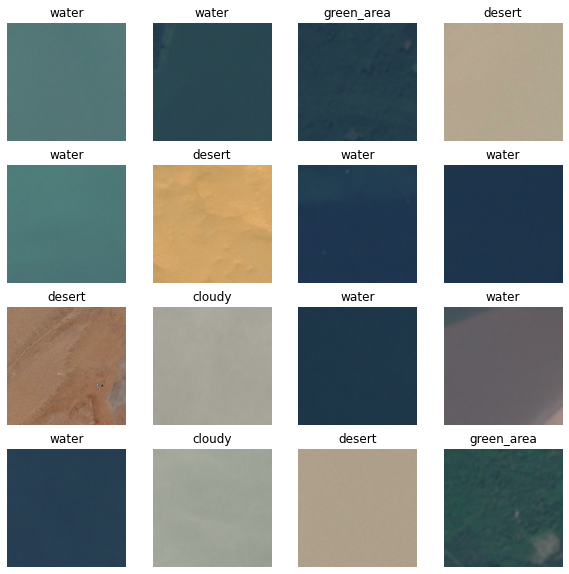

In [ ]:
#visualización de imagenes/datos
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [ ]:
#Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a 
#bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
#Dataset.prefetch overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#MODEL

num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
# model.build()
# model.summary()

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
123/123 [==============================] - 362s 3s/step - loss: 0.5505 - accuracy: 0.7327 - val_loss: 0.3905 - val_accuracy: 0.8439
Epoch 2/50
123/123 [==============================] - 6s 51ms/step - loss: 0.3518 - accuracy: 0.8547 - val_loss: 0.3548 - val_accuracy: 0.8427
Epoch 3/50
123/123 [==============================] - 6s 51ms/step - loss: 0.3279 - accuracy: 0.8656 - val_loss: 0.3649 - val_accuracy: 0.8498
Epoch 4/50
123/123 [==============================] - 6s 51ms/step - loss: 0.3184 - accuracy: 0.8712 - val_loss: 0.3183 - val_accuracy: 0.8674
Epoch 5/50
123/123 [==============================] - 6s 53ms/step - loss: 0.3202 - accuracy: 0.8704 - val_loss: 0.3189 - val_accuracy: 0.8638
Epoch 6/50
123/123 [==============================] - 6s 51ms/step - loss: 0.2988 - accuracy: 0.8783 - val_loss: 0.3373 - val_accuracy: 0.8615
Epoch 7/50
123/123 [==============================] - 6s 51ms/step - loss: 0.2961 - accuracy: 0.8725 - val_loss: 0.2809 - val_accuracy: 0.8979

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9

Text(0.5, 1.0, 'Training and Validation Accuracy')

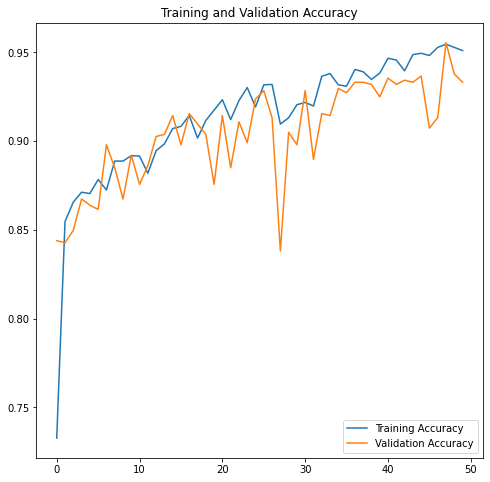

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

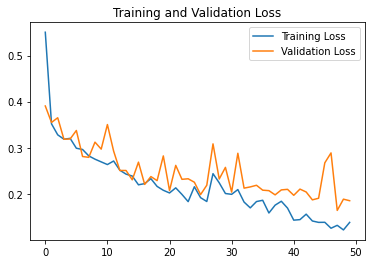

In [ ]:
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/AI_HACKATHON/DATOS_IMAGENES/modelo_david.h5")

In [ ]:
score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1837323158979416
Test accuracy: 0.9336493015289307
